# Stock Index Time Series

In [147]:
!pip install yfinance
!pip install statsmodels
!pip install gluonts
!pip install mxnet

In [148]:
import os 
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
from pprint import pprint

In [149]:
from gluonts.dataset.common import ListDataset
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
import mxnet as mx 

In [150]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'Mean Square Error is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'Mean Absolute Error is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'Root Mean Square Error is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'Mean Absolute Percentage Error is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 score is : {metrics.r2_score(y_true, y_pred)}',end='\n\n') 

## S&P 500 index (SPY) Time series

In [151]:
ticker = yf.download("SPY", start='2005-01-01')
ticker['Date'] = ticker.index
ticker.head()

[*********************100%***********************]  1 of 1 completed


Open        High         Low       Close  Adj Close  \
Date                                                                    
2004-12-31  121.300003  121.660004  120.800003  120.870003  86.411926   
2005-01-03  121.559998  121.760002  119.900002  120.300003  86.004410   
2005-01-04  120.459999  120.540001  118.440002  118.830002  84.953514   
2005-01-05  118.739998  119.250000  118.000000  118.010002  84.367256   
2005-01-06  118.440002  119.150002  118.260002  118.610001  84.796204   

              Volume       Date  
Date                             
2004-12-31  28648800 2004-12-31  
2005-01-03  55748000 2005-01-03  
2005-01-04  69167600 2005-01-04  
2005-01-05  65667300 2005-01-05  
2005-01-06  47814700 2005-01-06

In [152]:
ticker.head()

Open        High         Low       Close  Adj Close  \
Date                                                                    
2004-12-31  121.300003  121.660004  120.800003  120.870003  86.411926   
2005-01-03  121.559998  121.760002  119.900002  120.300003  86.004410   
2005-01-04  120.459999  120.540001  118.440002  118.830002  84.953514   
2005-01-05  118.739998  119.250000  118.000000  118.010002  84.367256   
2005-01-06  118.440002  119.150002  118.260002  118.610001  84.796204   

              Volume       Date  
Date                             
2004-12-31  28648800 2004-12-31  
2005-01-03  55748000 2005-01-03  
2005-01-04  69167600 2005-01-04  
2005-01-05  65667300 2005-01-05  
2005-01-06  47814700 2005-01-06

We will focus on the 'Adj Close' in our analysis 

In [153]:
ticker = ticker[['Adj Close']]
ticker.head() 

Adj Close
Date                 
2004-12-31  86.411926
2005-01-03  86.004410
2005-01-04  84.953514
2005-01-05  84.367256
2005-01-06  84.796204

In [154]:
ticker = ticker.rename(columns={'Adj Close': 'Adj_Close'})
ticker.tail()

Adj_Close
Date                  
2022-04-04  456.799988
2022-04-05  451.029999
2022-04-06  446.519989
2022-04-07  448.769989
2022-04-08  446.820007

In [155]:
# set the time series freq to Business day
ticker = ticker.asfreq('B')

<AxesSubplot:xlabel='Date'>

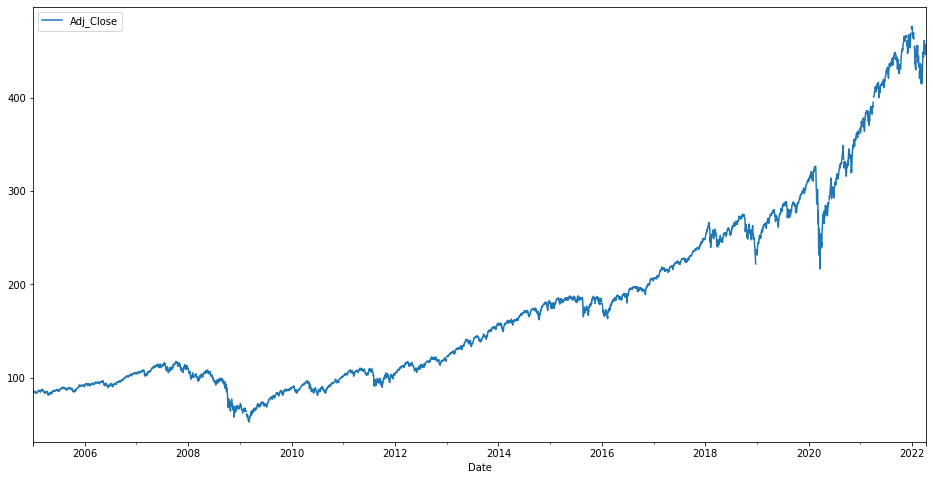

In [156]:
ticker.plot(figsize=(16,8))

In [157]:
ticker.index

DatetimeIndex(['2004-12-31', '2005-01-03', '2005-01-04', '2005-01-05',
               '2005-01-06', '2005-01-07', '2005-01-10', '2005-01-11',
               '2005-01-12', '2005-01-13',
               ...
               '2022-03-28', '2022-03-29', '2022-03-30', '2022-03-31',
               '2022-04-01', '2022-04-04', '2022-04-05', '2022-04-06',
               '2022-04-07', '2022-04-08'],
              dtype='datetime64[ns]', name='Date', length=4506, freq='B')

In [158]:
from datetime import datetime, timedelta
train_dataset_end = datetime(2020,12,31)
test_dataset_end = datetime(2022,4,7)

In [159]:
train_data = ticker[:train_dataset_end]
test_data = ticker[train_dataset_end+timedelta(days=1):test_dataset_end]

In [160]:
test_data

Adj_Close
Date                  
2021-01-01         NaN
2021-01-04  362.811646
2021-01-05  365.310486
2021-01-06  367.494476
2021-01-07  372.954498
...                ...
2022-04-01  452.920013
2022-04-04  456.799988
2022-04-05  451.029999
2022-04-06  446.519989
2022-04-07  448.769989

[330 rows x 1 columns]

In [161]:
ticker['adj close differencing'] = ticker['Adj_Close'] - ticker['Adj_Close'].shift(1)  
ticker['adj close second differencing'] = ticker['adj close differencing'] - ticker['adj close differencing'].shift(1) 

In [162]:
from statsmodels.tsa.stattools import adfuller 

In [163]:
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [164]:
adf_test(ticker['adj close differencing'].dropna())

ADF Statistics: -13.965422228600437
p- value: 4.442052719437558e-26
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


One times differencing to get p < 0.05. Integration value: d = 1

In [165]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

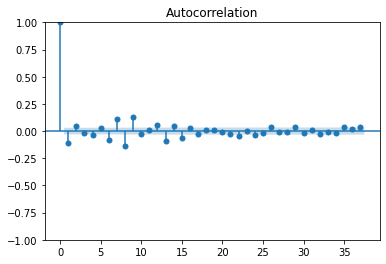

In [166]:
acf = plot_acf(ticker['adj close differencing'].dropna())

MA q = 9

/Users/wismineffendi/opt/anaconda3/envs/time-series/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


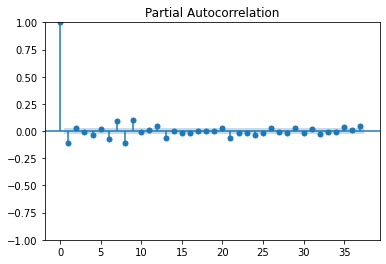

In [167]:
pacf = plot_pacf(ticker['adj close differencing'].dropna())

AR p = 9

In [168]:
## create an ARIMA model
from statsmodels.tsa.arima.model import ARIMA
model_ARIMA = ARIMA(train_data['Adj_Close'], order=(9,1,9))
model_ARIMA_fit = model_ARIMA.fit()
model_ARIMA_fit.summary()

/Users/wismineffendi/opt/anaconda3/envs/time-series/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/wismineffendi/opt/anaconda3/envs/time-series/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj_Close   No. Observations:                 4175
Model:                 ARIMA(9, 1, 9)   Log Likelihood               -8377.374
Date:                Fri, 08 Apr 2022   AIC                          16792.747
Time:                        21:23:46   BIC                          16913.143
Sample:                    12-31-2004   HQIC                         16835.333
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1192      0.030     -3.939      0.000      -0.178      -0.060
ar.L2          0.3065      0.041      7.404      0.000       0.225       0.388
ar.L3          0.0532      0.035      1.528      0.126      -0.015       0.122
ar.L4         -0.1820      0.027     -6.788      0.000      -0.235      -0.129
ar.L5          0.3427      0.024     14.178      0.000       0.295       0.390
ar.L6         -0.3974      0.027    -14.738      0.000      -0.450      -0.345
ar.L7         -0.3470      0.030    -11.536      0.000      -0.406      -0.288
ar.L8          0.3398      0.032     10.504      0.000       0.276       0.403
ar.L9          0.5874      0.038     15.427      0.000       0.513       0.662
ma.L1          0.0134      0.032      0.411      0.681      -0.050       0.077
ma.L2         -0.2761      0.043     -6.442      0.000      -0.360      -0.192
ma.L3         -0.0066      0.035     -0.191      0.849      -0.074       0.061
ma.L4          0.1458      0.029      5.097      0.000       0.090       0.202
ma.L5         -0.3190      0.025    -12.883      0.000      -0.368      -0.270
ma.L6          0.3936      0.027     14.670      0.000       0.341       0.446
ma.L7          0.3878      0.030     12.764      0.000       0.328       0.447
ma.L8         -0.4251      0.032    -13.183      0.000      -0.488      -0.362
ma.L9         -0.4183      0.039    -10.761      0.000      -0.494      -0.342
sigma2         3.5911      0.028    126.378      0.000       3.535       3.647
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):            108939.71
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               5.43   Skew:                            -1.46
Prob(H) (two-sided):                  0.00   Kurtosis:                        27.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [169]:
# prediction 
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]
print(pred_start_date)
print(pred_end_date)

2021-01-01 00:00:00
2022-04-07 00:00:00


In [170]:
pred=model_ARIMA_fit.predict(start=pred_start_date,end=pred_end_date)
residuals=test_data['Adj_Close']-pred

In [171]:
pred

2021-01-01    367.202444
2021-01-04    368.001014
2021-01-05    367.622066
2021-01-06    367.467230
2021-01-07    367.267158
                 ...    
2022-04-01    369.465763
2022-04-04    369.462920
2022-04-05    369.684205
2022-04-06    369.750995
2022-04-07    369.549259
Freq: B, Name: predicted_mean, Length: 330, dtype: float64

In [172]:
residuals

Date
2021-01-01          NaN
2021-01-04    -5.189368
2021-01-05    -2.311580
2021-01-06     0.027246
2021-01-07     5.687341
                ...    
2022-04-01    83.454250
2022-04-04    87.337068
2022-04-05    81.345794
2022-04-06    76.768994
2022-04-07    79.220730
Freq: B, Length: 330, dtype: float64

<AxesSubplot:ylabel='Density'>

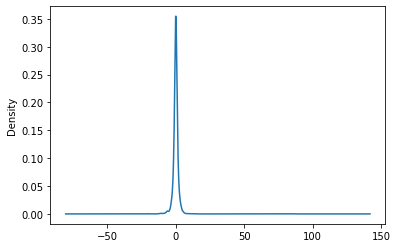

In [173]:
model_ARIMA_fit.resid.plot(kind='kde')

In [174]:
test_data['Predicted_ARIMA'] = pred

/var/folders/pt/fssyv3nx7f1dx2s0jz0zzdpw0000gn/T/ipykernel_8967/284031954.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted_ARIMA'] = pred


<AxesSubplot:xlabel='Date'>

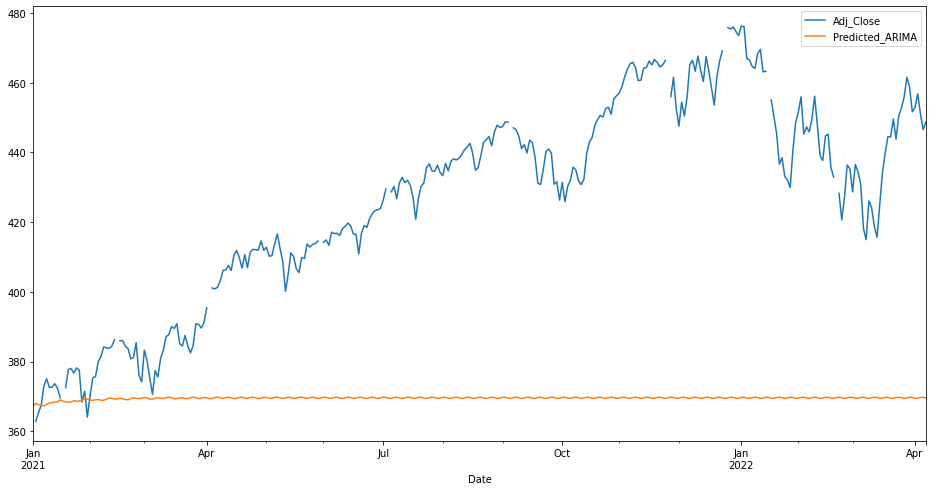

In [175]:
test_data[['Adj_Close', 'Predicted_ARIMA']].plot(figsize=(16,8))

In [176]:
# create a SARIMAX model 
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [177]:
ticker['adj close monthly differencing'] = ticker['Adj_Close'] - ticker['Adj_Close'].shift(30) # montly 


In [178]:
adf_test(ticker['adj close monthly differencing'].dropna())

ADF Statistics: -7.4983974914360845
p- value: 4.318133435799286e-11
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


/Users/wismineffendi/opt/anaconda3/envs/time-series/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


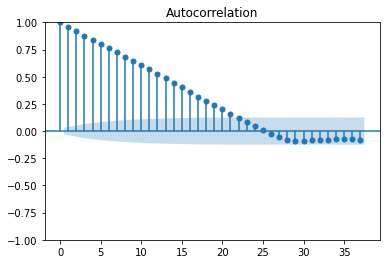

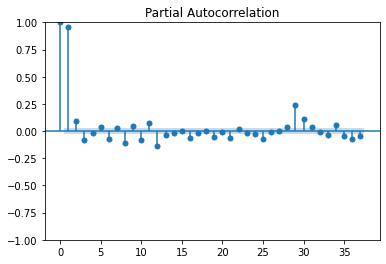

In [181]:
acf12 = plot_acf(ticker['adj close monthly differencing'].dropna())
pacf12 = plot_pacf(ticker['adj close monthly differencing'].dropna())

AR p=29, MA q=20, I d=1

In [182]:
model_SARIMAX = SARIMAX(train_data['Adj_Close'], order=(29,1,20), seasonal_order=(0,0,0,30))
model_SARIMAX_fit = model_SARIMAX.fit()
model_SARIMAX_fit.summary()

/Users/wismineffendi/opt/anaconda3/envs/time-series/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/wismineffendi/opt/anaconda3/envs/time-series/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           50     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.04972D+00    |proj g|=  1.72707D-01


 This problem is unconstrained.



At iterate    5    f=  1.99932D+00    |proj g|=  2.69277D-03

At iterate   10    f=  1.99819D+00    |proj g|=  3.20523D-02

At iterate   15    f=  1.99698D+00    |proj g|=  3.26042D-03

At iterate   20    f=  1.99642D+00    |proj g|=  9.89260D-03

At iterate   25    f=  1.99578D+00    |proj g|=  4.53808D-03

At iterate   30    f=  1.99548D+00    |proj g|=  6.10862D-03

At iterate   35    f=  1.99510D+00    |proj g|=  5.95951D-03

At iterate   40    f=  1.99484D+00    |proj g|=  6.04840D-03

At iterate   45    f=  1.99454D+00    |proj g|=  1.86559D-02


/Users/wismineffendi/opt/anaconda3/envs/time-series/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.99421D+00    |proj g|=  7.11589D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   50     50     55      1     0     0   7.116D-03   1.994D+00
  F =   1.9942068783775460     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj_Close   No. Observations:                 4175
Model:             SARIMAX(29, 1, 20)   Log Likelihood               -8325.814
Date:                Fri, 08 Apr 2022   AIC                          16751.627
Time:                        21:27:44   BIC                          17068.459
Sample:                    12-31-2004   HQIC                         16863.693
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0681      3.105     -0.022      0.983      -6.153       6.017
ar.L2         -0.0888      0.437     -0.203      0.839      -0.946       0.768
ar.L3          0.1595      0.511      0.312      0.755      -0.842       1.161
ar.L4         -0.1432      0.324     -0.441      0.659      -0.779       0.493
ar.L5         -0.1675      0.396     -0.423      0.672      -0.944       0.609
ar.L6         -0.2733      0.545     -0.501      0.616      -1.342       0.795
ar.L7         -0.0242      0.930     -0.026      0.979      -1.848       1.799
ar.L8          0.0096      0.243      0.039      0.969      -0.467       0.487
ar.L9          0.4077      0.194      2.098      0.036       0.027       0.789
ar.L10        -0.0975      1.327     -0.074      0.941      -2.698       2.503
ar.L11         0.0757      0.474      0.160      0.873      -0.853       1.005
ar.L12        -0.3614      0.333     -1.086      0.277      -1.014       0.291
ar.L13        -0.0158      1.014     -0.016      0.988      -2.003       1.972
ar.L14        -0.2099      0.198     -1.059      0.290      -0.599       0.179
ar.L15         0.1892      0.633      0.299      0.765      -1.051       1.429
ar.L16        -0.0339      0.641     -0.053      0.958      -1.290       1.222
ar.L17        -0.2634      0.247     -1.068      0.286      -0.747       0.220
ar.L18        -0.4882      0.768     -0.635      0.525      -1.994       1.017
ar.L19        -0.0647      1.473     -0.044      0.965      -2.952       2.822
ar.L20        -0.0029      0.199     -0.014      0.988      -0.392       0.386
ar.L21         0.0972      0.174      0.559      0.576      -0.244       0.438
ar.L22        -0.0401      0.243     -0.165      0.869      -0.517       0.437
ar.L23        -0.0572      0.119     -0.483      0.629      -0.290       0.175
ar.L24        -0.0193      0.193     -0.100      0.920      -0.397       0.358
ar.L25        -0.0009      0.099     -0.009      0.993      -0.194       0.192
ar.L26         0.0039      0.088      0.044      0.965      -0.168       0.176
ar.L27        -0.0248      0.076     -0.328      0.743      -0.173       0.123
ar.L28         0.0637      0.042      1.506      0.132      -0.019       0.147
ar.L29         0.0084      0.188      0.045      0.964      -0.359       0.376
ma.L1         -0.0445      3.105     -0.014      0.989      -6.130       6.041
ma.L2          0.1461      0.625      0.234      0.815      -1.079       1.371
ma.L3         -0.1270      0.659     -0.193      0.847      -1.419       1.165
ma.L4          0.1050      0.333      0.315      0.753      -0.548       0.758
ma.L5          0.1549      0.307      0.505      0.614      -0.447       0.756
ma.L6          0.1758      0.577      0.304      0.761      -0.956       1.307
ma.L7          0.1464      0.665      0.220      0.826      -1.157       1.450
ma.L8         -0.0930      0.376     -0.247      0.805      -0.830       0.644
ma.L9         -0.2555      0.164     -1.559      0.119      -0.577       0.066
ma

In [183]:
pred_SARIMAX = model_SARIMAX_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data['Adj_Close'] - pred_SARIMAX

<AxesSubplot:xlabel='Date'>

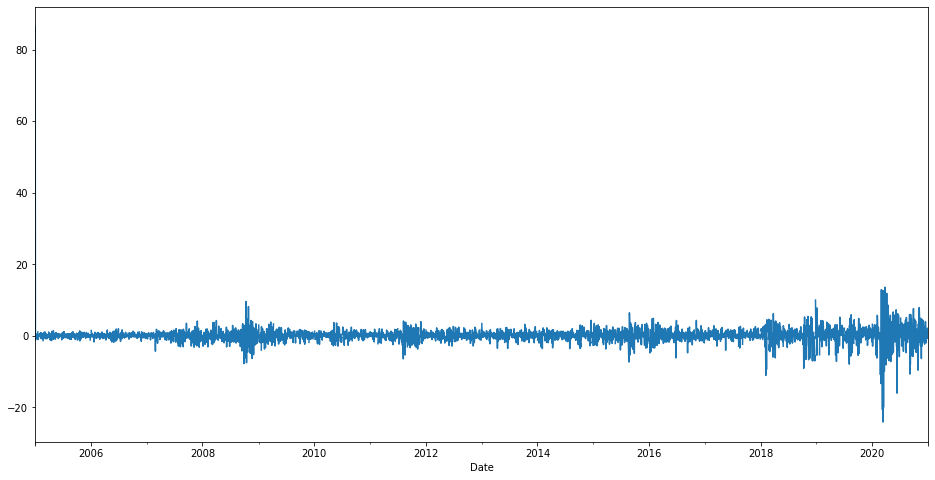

In [184]:
model_SARIMAX_fit.resid.plot(figsize=(16,8))

<AxesSubplot:ylabel='Density'>

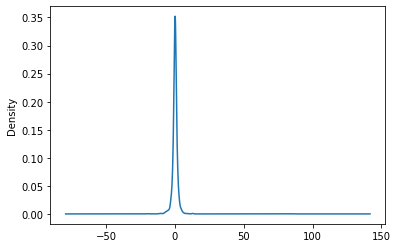

In [185]:
model_SARIMAX_fit.resid.plot(kind='kde')

In [186]:
test_data['Predicted_SARIMAX'] = pred_SARIMAX

/var/folders/pt/fssyv3nx7f1dx2s0jz0zzdpw0000gn/T/ipykernel_8967/1953269687.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted_SARIMAX'] = pred_SARIMAX


<AxesSubplot:xlabel='Date'>

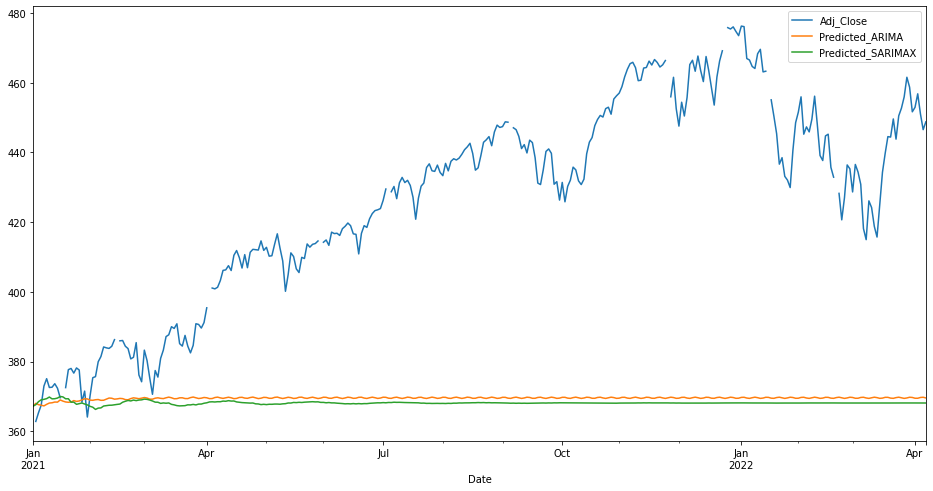

In [187]:
test_data[['Adj_Close', 'Predicted_ARIMA', 'Predicted_SARIMAX']].plot(figsize=(16,8))

## Prophet

In [188]:
!pip install prophet

In [189]:
from prophet import Prophet

In [190]:
train_df = train_data.reset_index()
test_df = test_data.reset_index()

In [191]:
proph_train = train_df[['Date', 'Adj_Close']].rename(columns={'Date':'ds', 'Adj_Close': 'y'})
proph_test = test_df[['Date','Adj_Close']].rename(columns={'Date':'ds', 'Adj_Close': 'y'})

In [192]:
proph_train.shape, proph_test.shape, train_df.shape, test_df.shape

((4175, 2), (330, 2), (4175, 2), (330, 4))

In [193]:
m = Prophet()
m.fit(proph_train)
future = m.make_future_dataframe(periods=len(proph_test), freq='B')
forecast = m.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/wismineffendi/opt/anaconda3/envs/time-series/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -90.045
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       12384.8    0.00728382       2038.65      0.7628      0.7628      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       12718.3     0.0149492       3618.21           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       12782.1    0.00338198       1029.81           1           1      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       12811.4     0.0100179       4318.18           1           1      456   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499         12840     0.0046809       1610.56           1           1      564   
    Iter      log prob        ||dx||      ||grad||       alpha   

/Users/wismineffendi/opt/anaconda3/envs/time-series/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/wismineffendi/opt/anaconda3/envs/time-series/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [194]:
forecast.head()

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2004-12-31  83.480452   74.153107   95.071001    83.480452    83.480452   
1 2005-01-03  83.550754   73.034148   94.848950    83.550754    83.550754   
2 2005-01-04  83.574188   73.429852   94.818631    83.574188    83.574188   
3 2005-01-05  83.597622   72.253905   94.658136    83.597622    83.597622   
4 2005-01-06  83.621056   73.628136   94.257369    83.621056    83.621056   

   additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
0        0.732329              0.732329              0.732329 -0.581020   
1        0.471634              0.471634              0.471634 -0.621436   
2        0.613659              0.613659              0.613659 -0.409618   
3        0.478351              0.478351              0.478351 -0.477020   
4        0.422039              0.422039              0.422039 -0.467234   

   weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
0     -0.581020     -0.581020  1.313349      1.313349      1.313349   
1     -0.621436     -0.621436  1.093069      1.093069      1.093069   
2     -0.409618     -0.409618  1.023277      1.023277      1.023277   
3     -0.477020     -0.477020  0.955371      0.955371      0.955371   
4     -0.467234     -0.467234  0.889273      0.889273      0.889273   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   
1                   0.0                         0.0   
2                   0.0                         0.0   
3                   0.0                         0.0   
4                   0.0                         0.0   

   multiplicative_terms_upper       yhat  
0                         0.0  84.212781  
1                         0.0  84.022388  
2                         0.0  84.187847  
3                         0.0  84.075973  
4                         0.0  84.043096

In [195]:
forecast.tail()

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
4500 2022-04-01  363.041166  341.008316  377.942880   347.201041   378.001591   
4501 2022-04-04  363.279240  342.138106  377.555352   347.195866   378.369969   
4502 2022-04-05  363.358598  340.731547  379.378281   347.198146   378.488465   
4503 2022-04-06  363.437957  339.775216  379.135719   347.227168   378.622334   
4504 2022-04-07  363.517315  341.617874  379.798004   347.260614   378.767599   

      additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
4500       -3.855241             -3.855241             -3.855241 -0.581020   
4501       -3.411122             -3.411122             -3.411122 -0.621436   
4502       -3.030833             -3.030833             -3.030833 -0.409618   
4503       -2.928925             -2.928925             -2.928925 -0.477020   
4504       -2.750402             -2.750402             -2.750402 -0.467234   

      weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
4500     -0.581020     -0.581020 -3.274221     -3.274221     -3.274221   
4501     -0.621436     -0.621436 -2.789686     -2.789686     -2.789686   
4502     -0.409618     -0.409618 -2.621215     -2.621215     -2.621215   
4503     -0.477020     -0.477020 -2.451905     -2.451905     -2.451905   
4504     -0.467234     -0.467234 -2.283168     -2.283168     -2.283168   

      multiplicative_terms  multiplicative_terms_lower  \
4500                   0.0                         0.0   
4501                   0.0                         0.0   
4502                   0.0                         0.0   
4503                   0.0                         0.0   
4504                   0.0                         0.0   

      multiplicative_terms_upper        yhat  
4500                         0.0  359.185925  
4501                         0.0  359.868118  
4502                         0.0  360.327765  
4503                         0.0  360.509031  
4504                         0.0  360.766913

In [196]:
test_data.tail()

Adj_Close  Predicted_ARIMA  Predicted_SARIMAX
Date                                                      
2022-04-01  452.920013       369.465763         368.107048
2022-04-04  456.799988       369.462920         368.104975
2022-04-05  451.029999       369.684205         368.103152
2022-04-06  446.519989       369.750995         368.104626
2022-04-07  448.769989       369.549259         368.099035

In [197]:
test_data.shape

(330, 3)

In [198]:
forecast[-330:].shape

(330, 19)

In [199]:
forecast.shape

(4505, 19)

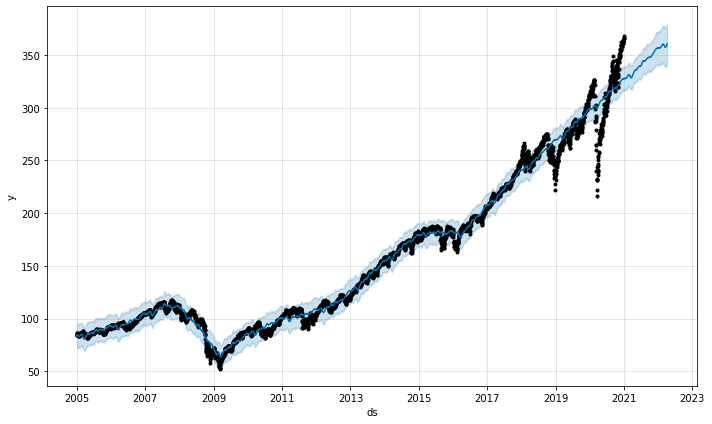

In [200]:
fig1 = m.plot(forecast)

/Users/wismineffendi/opt/anaconda3/envs/time-series/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/wismineffendi/opt/anaconda3/envs/time-series/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


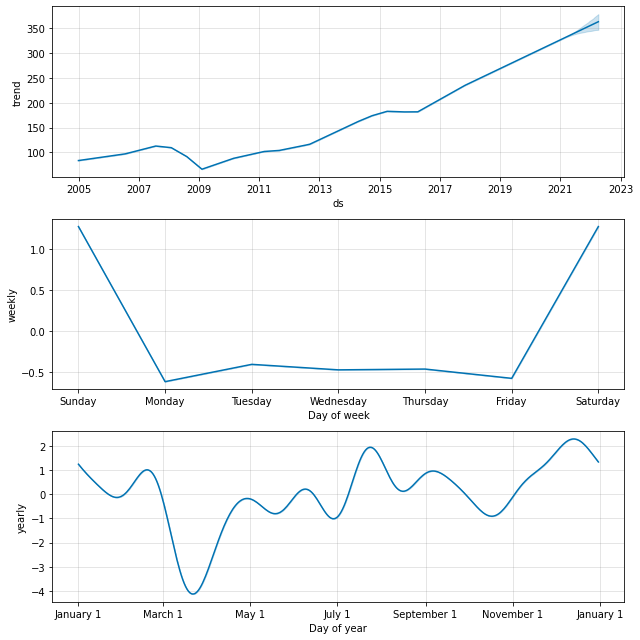

In [201]:
fig2 = m.plot_components(forecast)

In [202]:
forecast[-330:][['ds', 'yhat']]

ds        yhat
4175 2021-01-01  327.590416
4176 2021-01-04  327.573115
4177 2021-01-05  327.796384
4178 2021-01-06  327.742243
4179 2021-01-07  327.766962
...         ...         ...
4500 2022-04-01  359.185925
4501 2022-04-04  359.868118
4502 2022-04-05  360.327765
4503 2022-04-06  360.509031
4504 2022-04-07  360.766913

[330 rows x 2 columns]

In [203]:
test_data.index

DatetimeIndex(['2021-01-01', '2021-01-04', '2021-01-05', '2021-01-06',
               '2021-01-07', '2021-01-08', '2021-01-11', '2021-01-12',
               '2021-01-13', '2021-01-14',
               ...
               '2022-03-25', '2022-03-28', '2022-03-29', '2022-03-30',
               '2022-03-31', '2022-04-01', '2022-04-04', '2022-04-05',
               '2022-04-06', '2022-04-07'],
              dtype='datetime64[ns]', name='Date', length=330, freq='B')

In [204]:
test_data['Predicted_Prophet'] = forecast[-330:][['ds', 'yhat']].set_index('ds')

/var/folders/pt/fssyv3nx7f1dx2s0jz0zzdpw0000gn/T/ipykernel_8967/1740450403.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted_Prophet'] = forecast[-330:][['ds', 'yhat']].set_index('ds')


In [205]:
test_data.head()

Adj_Close  Predicted_ARIMA  Predicted_SARIMAX  Predicted_Prophet
Date                                                                         
2021-01-01         NaN       367.202444         367.200021         327.590416
2021-01-04  362.811646       368.001014         367.607710         327.573115
2021-01-05  365.310486       367.622066         368.483713         327.796384
2021-01-06  367.494476       367.467230         369.019686         327.742243
2021-01-07  372.954498       367.267158         369.144499         327.766962

<AxesSubplot:xlabel='Date'>

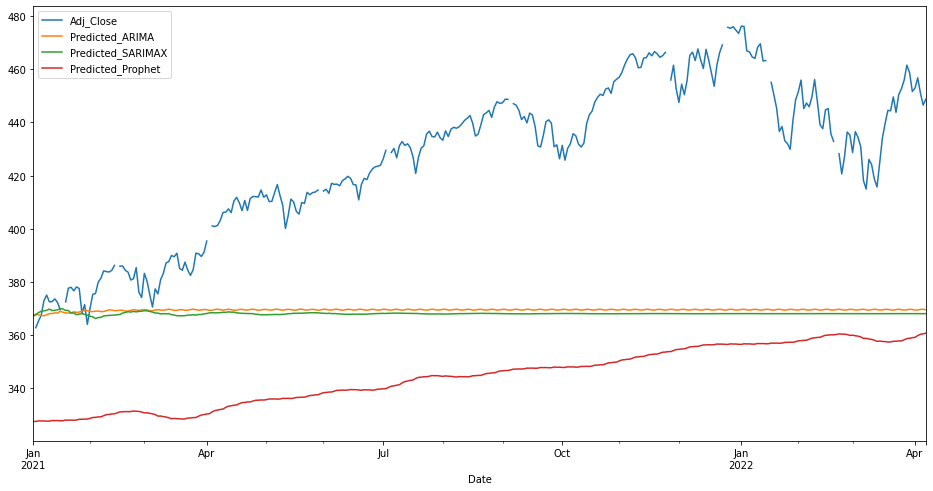

In [206]:
test_data[['Adj_Close', 'Predicted_ARIMA', 'Predicted_SARIMAX',
           'Predicted_Prophet']].plot(figsize=(16,8))

### DeepAR

In [207]:
train_data.head()

Adj_Close
Date                 
2004-12-31  86.411926
2005-01-03  86.004410
2005-01-04  84.953514
2005-01-05  84.367256
2005-01-06  84.796204

In [208]:
start = pd.Timestamp("2021-1-1", freq="B")
train_ds = ListDataset([{'target': train_data.Adj_Close, 'start': start}], freq='B')

/var/folders/pt/fssyv3nx7f1dx2s0jz0zzdpw0000gn/T/ipykernel_8967/351675586.py:1: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  start = pd.Timestamp("2021-1-1", freq="B")


Test dataset: use the whole dataset, add 'target' and 'start' field

In [209]:
test_ds = ListDataset([{'target': ticker.Adj_Close, 'start': start}], freq='B')

In [210]:
np.random.seed(42)
mx.random.seed(42)

estimator = DeepAREstimator(
    prediction_length=330,
    context_length=350,
    freq='B',
    trainer=Trainer( # ctx="gpu",
                    epochs=25, learning_rate=1e-3, num_batches_per_epoch=100)
)
predictor = estimator.train(train_ds)

/Users/wismineffendi/opt/anaconda3/envs/time-series/lib/python3.9/site-packages/gluonts/transform/feature.py:343: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/time-series/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/wismineffendi/opt/anaconda3/envs/time-series/lib/python3.9/site-packages/gluonts/transform/feature.py:384: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  ..., i0 : i0 + length * start.freq.n : start.freq.n
INFO:gluonts.trainer:Start model training
INFO:gluonts.trainer:Epoch[0] Learning rate is 0.001
  0%|                                                                                              | 0/100 [00:00<?, ?it/s]/Users/wismineffendi/opt/anaconda3/envs/time

In [211]:
predictions = predictor.predict(test_ds)
predictions = list(predictions)[0]
predictions = predictions.quantile(0.5)

/Users/wismineffendi/opt/anaconda3/envs/time-series/lib/python3.9/site-packages/gluonts/transform/feature.py:384: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  ..., i0 : i0 + length * start.freq.n : start.freq.n
/Users/wismineffendi/opt/anaconda3/envs/time-series/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)


In [212]:
test_df.head()

Date   Adj_Close  Predicted_ARIMA  Predicted_SARIMAX
0 2021-01-01         NaN       367.202444         367.200021
1 2021-01-04  362.811646       368.001014         367.607710
2 2021-01-05  365.310486       367.622066         368.483713
3 2021-01-06  367.494476       367.467230         369.019686
4 2021-01-07  372.954498       367.267158         369.144499

In [213]:
pred_df = pd.DataFrame(predictions)
pred_df.columns = ['Pred_Adj_Close']
pred_df

Pred_Adj_Close
0        458.195038
1        454.561676
2        455.956726
3        458.681763
4        461.844238
..              ...
325      674.701660
326      673.385071
327      669.480408
328      672.936768
329      674.145264

[330 rows x 1 columns]

In [214]:
test_data['Predicted_DeepAR'] = pd.concat([test_df.Date, pred_df], axis=1).set_index('Date')

/var/folders/pt/fssyv3nx7f1dx2s0jz0zzdpw0000gn/T/ipykernel_8967/3866931146.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted_DeepAR'] = pd.concat([test_df.Date, pred_df], axis=1).set_index('Date')


<AxesSubplot:xlabel='Date'>

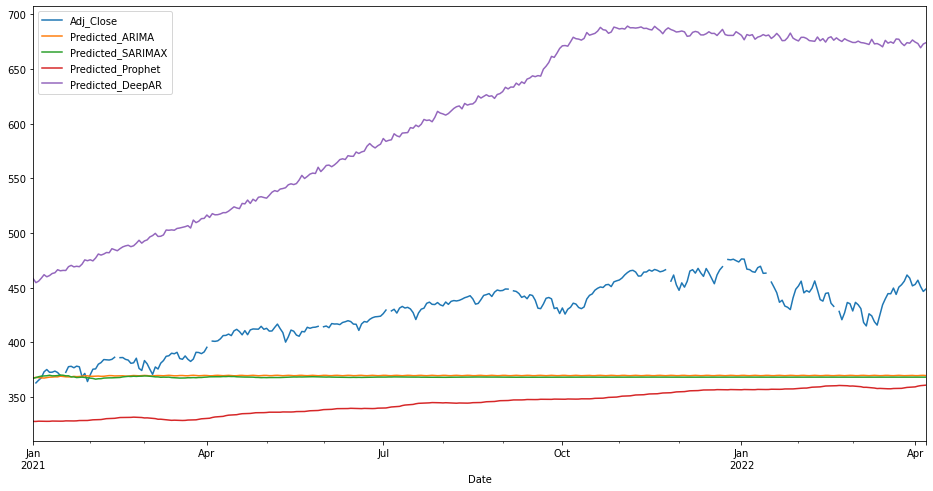

In [215]:
test_data[['Adj_Close', 'Predicted_ARIMA', 'Predicted_SARIMAX', 
           'Predicted_Prophet', 'Predicted_DeepAR']].plot(figsize=(16,8))

## Metrics

In [216]:
test_data.dropna(subset=['Adj_Close'], how='all', inplace=True)

/var/folders/pt/fssyv3nx7f1dx2s0jz0zzdpw0000gn/T/ipykernel_8967/2287834177.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.dropna(subset=['Adj_Close'], how='all', inplace=True)


In [217]:
timeseries_evaluation_metrics_func(test_data.Adj_Close, test_data.Predicted_ARIMA)

Evaluation metric results:-
Mean Square Error is : 4083.420664866004
Mean Absolute Error is : 57.18128593373462
Root Mean Square Error is : 63.90164837362182
Mean Absolute Percentage Error is : 12.99830276035045
R2 score is : -3.896327548366332



In [218]:
timeseries_evaluation_metrics_func(test_data.Adj_Close, test_data.Predicted_SARIMAX)

Evaluation metric results:-
Mean Square Error is : 4255.086275791296
Mean Absolute Error is : 58.552326287444714
Root Mean Square Error is : 65.2310223420674
Mean Absolute Percentage Error is : 13.317189973817465
R2 score is : -4.1021674871981615



In [219]:
timeseries_evaluation_metrics_func(test_data.Adj_Close, test_data.Predicted_Prophet)

Evaluation metric results:-
Mean Square Error is : 7124.36874488901
Mean Absolute Error is : 81.94563203115308
Root Mean Square Error is : 84.40597576527985
Mean Absolute Percentage Error is : 18.979105931598593
R2 score is : -7.542652303853394



In [220]:
timeseries_evaluation_metrics_func(test_data.Adj_Close, test_data.Predicted_DeepAR)

Evaluation metric results:-
Mean Square Error is : 34323.04519281465
Mean Absolute Error is : 177.90806479140136
Root Mean Square Error is : 185.2647975002662
Mean Absolute Percentage Error is : 41.19248966309655
R2 score is : -40.15590469710171



### Conclusion:

Based on MSE and MAE values, the ARIMA model provide the best prediction. But the R2 score negative at -3.89 suggest we can't trust this model.  